# Fine-tuning models

Note: before running code in this notebook, make sure GPU is being used. Go to edit > notebook settings > and select GPU under Hardware accelerator

Base model:

In [ ]:
model_checkpoint = 'bert-base-uncased'

Finetuned version of model above

In [ ]:
hub_model_id = 'repro-rights-amicus-briefs/legal-bert-base-uncased-finetuned-RRamicus'

# Set up environment

1. Load required packages
2. Log into HuggingFace w/access token
3. Load dataset from HuggingFace website

In [ ]:
! pip install transformers
! pip install torch
! pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

from html import unescape
from random import randint
import math

from transformers import pipeline
from datasets import load_dataset, load_metric, Dataset
from transformers import AutoTokenizer
from huggingface_hub import notebook_login
import torch as torch

Mount google drive to read in labeled dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/amicus-iv

Mounted at /content/gdrive
/content/gdrive/My Drive/amicus-iv


Log into huggingface to access the amicus files as a transformers dataset object

In [ ]:
# run this once at the start of the session so it saves the token you enter
# in the login in the next code chunk
!git config --global credential.helper store

In [ ]:
# get access token on Huggingface website > settings > access token (make sure it's a write token)
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


# Cross-model comparison task: Label set 1

Using the model with the highest perplexity score, check the accuracy on our labeled dataset

Labels:
* fem: women's rights, undue burden, complusory motherhood, women's citizenship, evidence, health
* opp: morality, abortion negative, psychological harm, fetus, evidence, health

## Read in manually labeled dataset

Set up drive access & read in csv

In [ ]:
# set up labels
labels_fem = ["women's rights", "undue burden", "compulsory motherhood", "woman's citizenship", "evidence", "health"]
labels_opp = ["morality", "abortion negative", "psychological harm", "fetus", "evidence", "health"]
labels = labels_fem + labels_opp[:-2]

In [ ]:
# pd DataFrame
eval_df = pd.read_csv('data/evaluation_dataset.csv')
eval_df.rename({'fem_brief':'brief_party'}, axis=1, inplace=True)

# turn labels column into a list (is currently a string with labels sep by col)
eval_df['labels'] = eval_df['labels'].str.replace("women's citizenship", "woman's citizenship")
eval_df["labels"] = [x.split(', ') for x in eval_df['labels']]

# Dataset
eval_ds = Dataset.from_pandas(eval_df)
eval_ds.features

{'brief': Value(dtype='string', id=None),
 'brief_party': Value(dtype='int64', id=None),
 'case': Value(dtype='string', id=None),
 'id': Value(dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'manu_label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

## Predict using classification pipeline

In [ ]:
# hyp template
hyp_temp = 'This example is about {}.'

# tokenizer 
class_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, truncation = True, max_length = 512, padding = 'max_length')

# pipeline
classifier = pipeline(task = 'zero-shot-classification', 
                      model = hub_model_id,
                      tokenizer = class_tokenizer,
                      hypothesis_template = hyp_temp,
                      batch_size = 8,
                      use_auth_token = True,
                      device = 0)

# function to apply to each element in dataset
def classifier_pipeline(example):
    # just init, should not use this category
    curr_labels = labels 
    if example['brief_party'] == 1:
      curr_labels = labels_fem
    else:
      curr_labels = labels_opp
    output = classifier(example['text'], curr_labels, multi_label=True, device=0)
    example['pred_labels'] = output['labels']
    example['pred_scores'] = output['scores']
    return example

Run the pipeline with the given labels on our evaluation dataset. Approx 30 seconds.

In [ ]:
# run on the eval dataset
eval_ds = eval_ds.map(classifier_pipeline)

0ex [00:00, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:999: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


## Accuracy metrics

Binarize the labels since we have multiple classes. The mlb function from sklearn turns labels (for ex: abortion negative, psy harm) into vectors (0, 1, 0, 0, 1, 0). 

In [ ]:
# binarize labels (since we have multiple classes)
# set up one for the fem briefs and one for the opp briefs
labels = labels_fem + labels_opp[:-2]
mlb = MultiLabelBinarizer(classes=labels)
#mlb_fem = MultiLabelBinarizer(classes=labels_fem)
#mlb_opp = MultiLabelBinarizer(classes=labels_opp)
mlb.fit(labels)
#mlb_fem.fit(labels_fem)
#mlb_opp.fit(labels_opp)

MultiLabelBinarizer(classes=["women's rights", 'undue burden',
                             'compulsory motherhood', "woman's citizenship",
                             'evidence', 'health', 'morality',
                             'abortion negative', 'psychological harm',
                             'fetus'])

Map the binarized labels to the text labels we have across our dataset. 

In [ ]:
# create a label_ids column for the truth
# binarize the labels 
def prepare_labels(batch):
    '''if batch['brief_party']==1:
      batch["label_ids"] = mlb_fem.transform(batch["labels"])
    else:
      batch["label_ids"] = mlb_opp.transform(batch["labels"])'''
    batch['label_ids'] = mlb.transform(batch['labels'])
    return batch

eval_ds = eval_ds.map(prepare_labels, batched=True, batch_size=20)

  0%|          | 0/6 [00:00<?, ?ba/s]

Classification report from sklearn (f1, precision, recall, etc.) 

In [ ]:
# function to get topk or threshold labels
def get_preds(example, threshold=None, topk=None):
    preds = []
    # get preds that meet threshold
    if threshold:
        for label, score in zip(example["pred_labels"], example["pred_scores"]):
            if score >= threshold:
                preds.append(label)
    # get preds that are topk highest scores
    elif topk:
        for i in range(topk):
            preds.append(example["pred_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")

    # save to dataset
    #if len(preds) > 0:
    #  example['pred_label_ids'] = list(np.squeeze(preds))
    #else:
    #  example['pred_label_ids'] = []

    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [ ]:
# classification report
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])

    '''if ds['brief_party']==1:
      return classification_report(
          y_true, y_pred, target_names=mlb_fem.classes_, zero_division=0, 
          output_dict=True)
    else:
      return classification_report(
          y_true, y_pred, target_names=mlb_opp.classes_, zero_division=0, 
          output_dict=True)'''
      
    return classification_report(
          y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
          output_dict=True)

Evaluate which of the thresholds / top k values are the best for this model. The best value will be used in the classification notebook. 

In [ ]:
# check accuracy with different topks
topk_macros, topk_micros = [], []
topks = [1, 2, 3, 4, 5, 6]
for topk in topks:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(eval_ds)
    topk_micros.append(clf_report['micro avg']['f1-score'])
    topk_macros.append(clf_report['macro avg']['f1-score'])

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

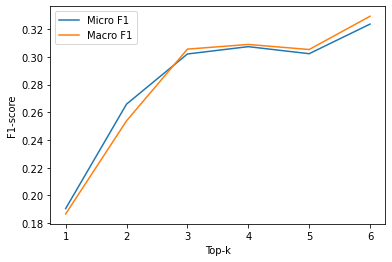

In [ ]:
plt.plot(topks, topk_micros, label='Micro F1')
plt.plot(topks, topk_macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

Check the thresholds

In [ ]:
# check accuracy with different thresholds
thresh_macros, thresh_micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(eval_ds)
    thresh_micros.append(clf_report["micro avg"]["f1-score"])
    thresh_macros.append(clf_report["macro avg"]["f1-score"])

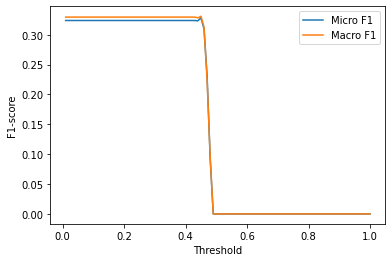

In [ ]:
plt.plot(thresholds, thresh_micros, label="Micro F1")
plt.plot(thresholds, thresh_macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

0ex [00:00, ?ex/s]

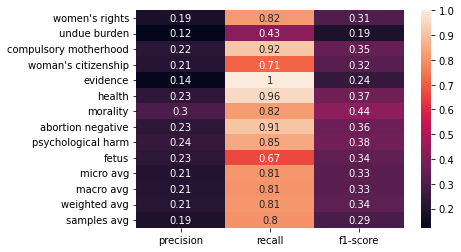

In [ ]:
# get predicted labels
best_threshold = thresholds[thresh_macros.index(max(thresh_macros))]
eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": best_threshold})
# classification report
clf_report = get_clf_report(eval_ds)
# plot
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

0ex [00:00, ?ex/s]

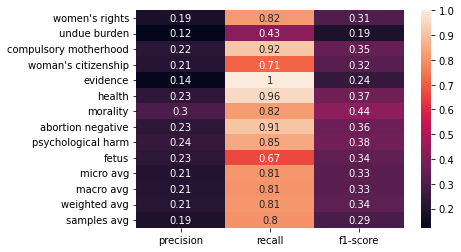

In [ ]:
# get predicted labels
best_micro_threshold = thresholds[thresh_micros.index(max(thresh_micros))]
eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": 0.45})
# classification report
clf_report = get_clf_report(eval_ds)
# plot
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

# Cross-model comparison task: Label set 2

Using the model with the highest perplexity score, check the accuracy on our labeled dataset

Labels:
* fem: abortion is women's right, undue burden standard, forces motherhood, women's career and education
* opp: lacks morality, abortion harmful, abortion causes psychological harm, fetus

In [ ]:
labels_fem = ['abortion is women\'s right', 'undue burden test', 'forces motherhood', 'women\'s career and education', 'mother or fetus health', 'evidence']
labels_opp = ['lacks morality', 'abortion harmful', 'abortion causes psychological harm', 'fetus', 'mother or fetus health', 'evidence']

## Read in manually labeled dataset

In [ ]:
# pd DataFrame
eval_df = pd.read_csv('data/evaluation_dataset.csv')
eval_df.rename({'fem_brief':'brief_party'}, axis=1, inplace=True)

label_map = {# opp labels
             'morality' : 'lacks morality',
             'abortion negative' : 'abortion harmful',
             'psychological harm' : 'abortion causes psychological harm',
             'fetus' : 'fetus',
             # fem labels
             'woman\'s citizenship' : 'women\'s career and education',
             'women\'s rights' : 'abortion is women\'s right',
             'compulsory motherhood' : 'forces motherhood',
             'undue burden' : 'undue burden test',
             # both
             'health' : 'mother or fetus health',
             'evidence' : 'evidence'}

# turn labels column into a list (is currently a string with labels sep by col)
eval_df['labels'] = eval_df['labels'].str.replace("women's citizenship", "woman's citizenship")
eval_df['labels'] = [x.split(', ') for x in eval_df['labels']]

# explode values (turn every element of list into new row)
eval_df = eval_df.explode('labels')

# map new values
eval_df['labels'] = eval_df['labels'].map(label_map)

# collapse dataframe - group by our identifying vars and concatenate labels back to list
eval_df = (eval_df.groupby(['case','brief', 'id', 'brief_party', 'text', 'manu_label'])
                    .agg({'labels': lambda x: x.tolist()})
                    .reset_index())

# Dataset
eval_ds = Dataset.from_pandas(eval_df)
eval_ds.features

{'brief': Value(dtype='string', id=None),
 'brief_party': Value(dtype='int64', id=None),
 'case': Value(dtype='string', id=None),
 'id': Value(dtype='int64', id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'manu_label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

## Predict using classification pipeline

Run the pipeline with the given labels on our evaluation dataset. Approx 30 seconds.

In [ ]:
# run on the eval dataset
eval_ds = eval_ds.map(classifier_pipeline)

0ex [00:00, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:999: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


## Accuracy metrics

Binarize the labels since we have multiple classes. The mlb function from sklearn turns labels (for ex: abortion negative, psy harm) into vectors (0, 1, 0, 0, 1, 0). 

In [ ]:
# binarize labels (since we have multiple classes)
# set up one for the fem briefs and one for the opp briefs
labels = labels_fem + labels_opp[:-2]
mlb = MultiLabelBinarizer(classes=labels)
#mlb_fem = MultiLabelBinarizer(classes=labels_fem)
#mlb_opp = MultiLabelBinarizer(classes=labels_opp)
mlb.fit(labels)
#mlb_fem.fit(labels_fem)
#mlb_opp.fit(labels_opp)

MultiLabelBinarizer(classes=["abortion is women's right", 'undue burden test',
                             'forces motherhood',
                             "women's career and education",
                             'mother or fetus health', 'evidence',
                             'lacks morality', 'abortion harmful',
                             'abortion causes psychological harm', 'fetus'])

Map the binarized labels to the text labels we have across our dataset. 

In [ ]:
# create a label_ids column for the truth
# binarize the labels 
def prepare_labels(batch):
    '''if batch['brief_party']==1:
      batch["label_ids"] = mlb_fem.transform(batch["labels"])
    else:
      batch["label_ids"] = mlb_opp.transform(batch["labels"])'''
    batch['label_ids'] = mlb.transform(batch['labels'])
    return batch

eval_ds = eval_ds.map(prepare_labels, batched=True, batch_size=20)

  0%|          | 0/6 [00:00<?, ?ba/s]

Evaluate which of the thresholds / top k values are the best for this model. The best value will be used in the classification notebook. 

In [ ]:
# check accuracy with different topks
topk_macros, topk_micros = [], []
topks = [1, 2, 3, 4, 5, 6]
for topk in topks:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(eval_ds)
    topk_micros.append(clf_report['micro avg']['f1-score'])
    topk_macros.append(clf_report['macro avg']['f1-score'])

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

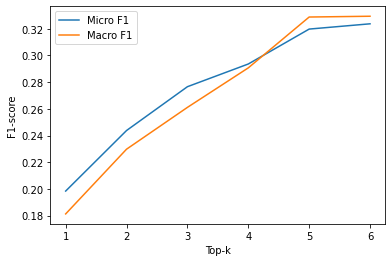

In [ ]:
plt.plot(topks, topk_micros, label='Micro F1')
plt.plot(topks, topk_macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

Check the thresholds

In [ ]:
# check accuracy with different thresholds
thresh_macros, thresh_micros = [], []

thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(eval_ds)
    thresh_micros.append(clf_report["micro avg"]["f1-score"])
    thresh_macros.append(clf_report["macro avg"]["f1-score"])

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

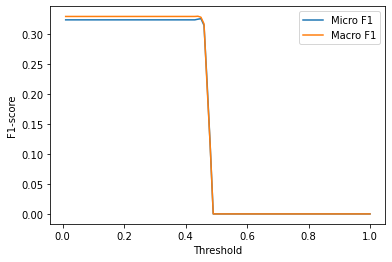

In [ ]:
plt.plot(thresholds, thresh_micros, label="Micro F1")
plt.plot(thresholds, thresh_macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

For the best f1 scores above, check how the model does at each label

**Precision**: true positives / true positives + false positives (aka, the percentage of the time it is correct when it predicts a label)

**Recall**: true positives / true positives + false negatives (aka, what percentage of the positives were correctly identified? the number of positives correctly detected divided by how all the positives were classified) 

For threshold = 0.4, our model has high recall, meaning we are consistently, across labels, identifying when these topics are mentioned. A recall of 1 for a given label means we did not have any false negatives -- there are no paragraphs, for example, where we predict evidence but the frame is not present. It struggles most here with undue burden standard. 

Precision is poor. This means we are often predicting labels that are not present... however, this is not necessarily a bad thing. We have some manually labeled texts and some automatically labeled. It's possible that in these auto texts (which represent approx. half of the data), multiple labels are present but we only gave it one. In this case, we may predict additional labels that were not recorded (aka, false positives). 

Therefore, we are not as concerned about poor precision as we are about poor recall!

0ex [00:00, ?ex/s]

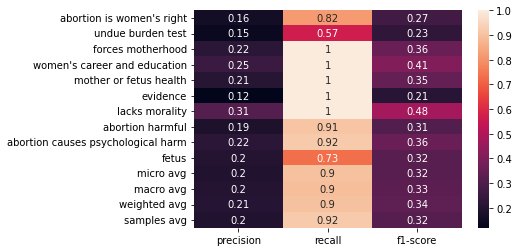

In [ ]:
# get predicted labels
eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": 0.4})
# classification report
clf_report = get_clf_report(eval_ds)
# plot
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

But, when we change the threshold to 0.5, recall becomes extremely poor. 

0ex [00:00, ?ex/s]

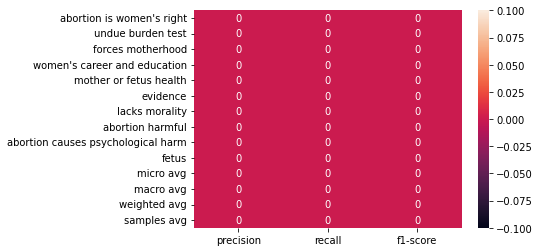

In [ ]:
# get predicted labels
eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"threshold": 0.5})
# classification report
clf_report = get_clf_report(eval_ds)
# plot
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

0ex [00:00, ?ex/s]

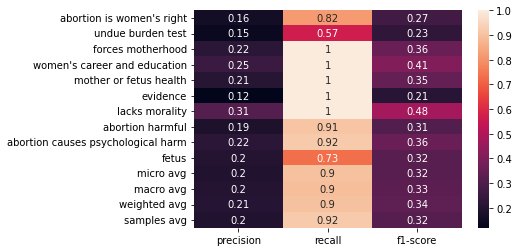

In [ ]:
# get predicted labels
eval_ds = eval_ds.map(get_preds, batched=False, fn_kwargs={"topk": 6})
# classification report
clf_report = get_clf_report(eval_ds)
# plot
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)